# Lab 1: Tokenisation and embeddings

In this lab, you will build an understanding of how text can be transformed into representations that computers can process and learn from. Specifically, you will explore two key concepts: *tokenisation* and *embeddings*. Tokenisation splits text into smaller units such as words, subwords, or characters. Embeddings are dense, fixed-size vector representations of tokens in a continuous space.

*Tasks you can choose for the oral exam are marked with the graduation cap 🎓 emoji.*

## Part 1: Tokenisation

In the first part of the lab, you will code and analyse a tokeniser based on the Byte Pair Encoding (BPE) algorithm.

### Utility functions

The BPE tokeniser transforms text into a list of integers representing tokens. As a warm-up, you will implement two utility functions on such lists. To simplify things, we define a shorthand for the type of pairs of integers:

In [120]:
type Pair = tuple[int, int]

#### 🎈 Task 1.01: Counting pairs

Write a function that counts all occurrences of pairs of consecutive token IDs in a given list. The function should return a dictionary that maps each pair to its count. Skip counts that are zero.

In [121]:
def count(ids: list[int]) -> dict[Pair, int]:
    """
    count is O(n) on ids
    """
    result = {}
    for i in range(len(ids) - 1):
        current_pair = (ids[i], ids[i + 1])
        # this operation is O(1) in python dicts
        if current_pair in result:
            result[current_pair] += 1
        else:
            result[current_pair] = 1
    return result

#### 🎈 Task 1.02: Replacing pairs

Write a function that traverses a list of token IDs from left to right and replaces all occurrences of a specified pair of consecutive IDs by a new ID. The function should return the modified list.

In [122]:
def replace(ids: list[int], pair: Pair, new_id: int) -> list[int]:
    result : list[int] = []
    i = 0
    while i < len(ids):
        if i == (len(ids) - 1):
            result.append(ids[i])
            return result
        current_pair = (ids[i], ids[i + 1])
        if current_pair == pair:
            result.append(new_id)
            i += 2
        else:
            result.append(ids[i])
            i += 1
    return result

In [123]:
print(replace([1,2,3], (1,2), 5))


[5, 3]


### Encoding and decoding

The next cell contains the core code for the tokeniser in the form of a class `Tokenizer`. This class implements two methods: `encode()` converts an input text to a list of token IDs by exhaustively applying rules for merging pairs of consecutive IDs (stored in the dictionary `self.merges`), and `decode()` reverses this process. Note that the set of merge rules is initially empty; you will add rules in Task&nbsp;1.04.

In [124]:
class Tokenizer:
    def __init__(self):
        """
        Initializes the tokenizer
        
        merges: dict[Pair, int] is a mapping of token pairs to a new token id
        vocab: dict[int, bytes] is a mapping between integers and the text string they represent
        in byte/hex-encoding.

        """
        self.merges: dict[Pair, int] = {}
        self.vocab: dict[int, bytes] = {i: bytes([i]) for i in range(2**8)}

    def encode(self, text: str) -> list[int]:
        """
        Encodes a text using the `merges` available from this object

        Outputs: a list of ids from the vocabulary that encode the given text string
        after performing merges of suitable token pairs.
        """
        ids = list(text.encode("utf-8"))
        while True:
            counts = count(ids)
            #  Get all keys from 
            mergeable_pairs = counts.keys() & self.merges.keys()
            if len(mergeable_pairs) == 0:
                break
            to_merge = min(mergeable_pairs, key=self.merges.get)
            ids = replace(ids, to_merge, self.merges[to_merge])
        return ids

    def decode(self, ids):
        """
        Takes a list of ids and converts back to their familiar utf-8
        string encoding, also known as normal strings.

        This is achieved using the vocab which maps ids to their bytestring
        encoding and then decodes the resulting bytestring into readable text
        using utf-8.
        """
        return b"".join((self.vocab[i] for i in ids)).decode("utf-8")

#### 🎓 Task 1.03: Encoding and decoding

**Question:** Explain how the code implements the BPE algorithm. Use the following steps to check your understanding:

**Step 1:** Annotate the attributes and methods of the `Tokenizer` class with their Python types. In particular, what is the type of `self.merges`? Use the `Pair` shorthand. What does a merge rule look like?

**Answer (Step 1.0):** Annotated functions can be seen in the above cells.

**Answer (Step 1.1):** 

**Q:** What is the type of `self.merges`?

**A:** The type of `self.merges` is 
```python
dict[Pair, int]
```

**Answer (Step 1.2):**

**Q:** What does a merge rule look like?

**A:** Here is an example of a merge rule:
```python
{(108,108): 257}
```

It takes two consecutive `l` characters and converts them to a new id `257` which is outside of the single-character range of utf-8 encodings. See below for answer in action:

In [125]:
t = Tokenizer()
t.merges = {(108,108): 257, (102,97): 258}
t.vocab[257] = b'll'
t.vocab[258] = b'fa'
t.decode(t.encode("Hello world jello fall fact"))

'Hello world jello fall fact'

**Step 2:** Explain how the implementation chooses which merge rule to apply. Provide an example that illustrates the logic. Construct the example such that you get a different result when you use `max()` instead of `min()`.

**Answer (Step 2):**

**A:** It chooses which merge rule to apply by taking the earliest learned index from the merge rule list (the minimal). In the below example, we see that merge rule `257` is used on the first pass in the `while` loop followed by rule `258`. The key part of the algorithm is the following condition:

```python
to_merge = min(mergeable_pairs, key=example_merges.get)
```

Now consider the following example string:

```
Hello world jello fall fact
```

and the following merge rules:

```
ll -> 257
al -> 258
```

The following substring `fall` will get two different tokenizations depending on whether the `al` rule or the `ll` rule gets applied first.

This takes the list of mergeable pairs from the current string and selects the earliest learned merge rule, as indicated by the `key=example_merges.get`. In this example, it is easy to see that since the keys `257` and `258` are such that `257<258`, then it follows that `min(257,258) != max(257,258)` since `257<258`.

In [126]:
# Setup
# This string has some repeated token  pairs, in particular `ll` and `al`
# which will be important to demonstrate the difference between min/max
example = "Hello world jello fall fact" 
example_merges = {}
ids = list(example.encode("utf-8"))

# Rule 257
t.vocab[257] = b'll'
example_merges[(108,108)] = 257
# Rule 258
t.vocab[258] = b'al'
example_merges[(102,97)] = 258

# Algorithm

# Below, we do first pass of the `encode` algorithm.
# While True
counts = count(ids)
mergeable_pairs = counts.keys() & example_merges.keys()

# This condition is false so we proceed
#if len(mergeable_pairs) == 0:
#    break
to_merge = max(mergeable_pairs, key=example_merges.get)
# Here! Clearlty, if we used max we would get 258, since we have
print("Using `max` to merge")
print("First pass")
print(f"Merged ids: {to_merge}: {example_merges[to_merge]}")
print(f"Old ids {ids}...")
ids = replace(ids, to_merge, example_merges[to_merge])
print(f"New ids: {ids[:3]}...")

# Second pass
print()
print("Second pass")
counts = count(ids)
mergeable_pairs = counts.keys() & example_merges.keys()
to_merge = min(mergeable_pairs, key=example_merges.get)
print(f"Merged ids: {to_merge}: {example_merges[to_merge]}")

print(f"Old ids ...{ids}...")
ids = replace(ids, to_merge, example_merges[to_merge])
print(f"New ids: ...{ids}...")

Using `max` to merge
First pass
Merged ids: (102, 97): 258
Old ids [72, 101, 108, 108, 111, 32, 119, 111, 114, 108, 100, 32, 106, 101, 108, 108, 111, 32, 102, 97, 108, 108, 32, 102, 97, 99, 116]...
New ids: [72, 101, 108]...

Second pass
Merged ids: (108, 108): 257
Old ids ...[72, 101, 108, 108, 111, 32, 119, 111, 114, 108, 100, 32, 106, 101, 108, 108, 111, 32, 258, 108, 108, 32, 258, 99, 116]...
New ids: ...[72, 101, 257, 111, 32, 119, 111, 114, 108, 100, 32, 106, 101, 257, 111, 32, 258, 257, 32, 258, 99, 116]...


In [127]:
# Setup
# This string has some repeated token  pairs, in particular `ll` and `al`
# which will be important to demonstrate the difference between min/max
example = "Hello world jello fall fact" 
example_merges = {}
ids = list(example.encode("utf-8"))

# Rule 257
t.vocab[257] = b'll'
example_merges[(108,108)] = 257
# Rule 258
t.vocab[258] = b'al'
example_merges[(102,97)] = 258

# Algorithm

# Below, we do first pass of the `encode` algorithm.
# While True
counts = count(ids)
mergeable_pairs = counts.keys() & example_merges.keys()

# This condition is false so we proceed
#if len(mergeable_pairs) == 0:
#    break
to_merge = min(mergeable_pairs, key=example_merges.get)
# Here! Clearlty, if we used min we would get 258, since we have
print("Using `min` to merge")
print("First pass")
print(f"Merged ids: {to_merge}: {example_merges[to_merge]}")
print(f"Old ids {ids}")
ids = replace(ids, to_merge, example_merges[to_merge])
print(f"New ids: {ids[:3]}")

# Second pass
print()
print("Second pass")
counts = count(ids)
mergeable_pairs = counts.keys() & example_merges.keys()
to_merge = min(mergeable_pairs, key=example_merges.get)
print(f"Merged ids: {to_merge}: {example_merges[to_merge]}")

print(f"Old ids {ids}")
ids = replace(ids, to_merge, example_merges[to_merge])
print(f"New ids: {ids}")

Using `min` to merge
First pass
Merged ids: (108, 108): 257
Old ids [72, 101, 108, 108, 111, 32, 119, 111, 114, 108, 100, 32, 106, 101, 108, 108, 111, 32, 102, 97, 108, 108, 32, 102, 97, 99, 116]
New ids: [72, 101, 257]

Second pass
Merged ids: (102, 97): 258
Old ids [72, 101, 257, 111, 32, 119, 111, 114, 108, 100, 32, 106, 101, 257, 111, 32, 102, 97, 257, 32, 102, 97, 99, 116]
New ids: [72, 101, 257, 111, 32, 119, 111, 114, 108, 100, 32, 106, 101, 257, 111, 32, 258, 257, 32, 258, 99, 116]


### Training a tokeniser

Upon initialisation, a tokeniser has an empty set of merge rules. Your next task is to complete the BPE algorithm and write code to learn these merge rules from a text.

#### 🎓 Task 1.04: Training a tokeniser

**Question:** Write a function that induces a BPE tokeniser from a given text. The function should take the text (a string) and a target vocabulary size as input and return the trained tokeniser.

In [128]:
def from_text(text: str, vocab_size: int, min_frequency: int = 2) -> Tokenizer:
    def infer_bytestring(pair: Pair, vocabulary: dict[int, bytes]) -> bytes:
        a, b = pair
        return vocabulary[a] + vocabulary[b]
    tok = Tokenizer()
    ids = list(text.encode("utf-8"))
    max_id = max(tok.vocab.keys())
    while len(tok.vocab) < vocab_size:
        # Step 1: Count occurrences of common byte-pairs
        counts = count(ids)
        
        if not counts: # or max(counts.values()) < min_frequency:
            # End early if no merge is above threshold
            return tok
        else:
            # Step 2: Infer most common Pair
            mergeable_pair = max(counts, key=counts.get)
            # Step 2: ... and grow merges and vocab
            tok.merges[mergeable_pair] = max_id + 1
            max_id = tok.merges[mergeable_pair]
            tok.vocab[max_id] = infer_bytestring(mergeable_pair, tok.vocab)
            ids = replace(ids, mergeable_pair, tok.merges[mergeable_pair])
            # Rinse and repeat
    return tok

In [129]:
# replace(ids: list[int], pair: Pair, new_id: int) -> list[int]:
counts = count(list("Hello world test1212 hello hello".encode('utf-8')))
mergable_pair = max(counts, key=counts.get)
t = Tokenizer()
max(t.vocab.keys())
tokenizer = from_text("hello world this is me training the tokenize, whats up?", 1024)

To help you test your implementation, we provide three text files together with tokenisers trained on these files. Each text file contains the first 1&nbsp;million Unicode characters in a language-specific Wikipedia:

| Text file | Tokeniser file | Wikipedia |
|---|---|---|
| `wiki-en-1m.txt` | `wiki-en-1m.tok` | [Simple English](https://simple.wikipedia.org/) |
| `wiki-is-1m.txt` | `wiki-is-1m.tok` | [Icelandic](https://is.wikipedia.org/) |
| `wiki-sv-1m.txt` | `wiki-sv-1m.tok` | [Swedish](https://sv.wikipedia.org/) |

A tokeniser file consists of lines specifying merge rules. For example, the first line in the tokeniser file for Swedish is `101 114`, which expresses that this rule combines the token with ID 101 (`e`) and the token with ID 114 (`r`). The ID of the new token (`er`) is 256 plus the (zero-indexed) line number on which the rule is found. The following code saves a `Tokenizer` to a file with this format:

In [130]:
def save(tokenizer: Tokenizer, filename: str) -> None:
    with open(filename, "w") as f:
        for fst, snd in tokenizer.merges:
            print(f"{fst} {snd}", file=f)


In [131]:
for file_name in ["wiki-en-1m.txt", "wiki-is-1m.txt", "wiki-sv-1m.txt"]:
    with open(file_name, "r") as fp:
        text = fp.read()
        tokenizer = from_text(text, vocab_size=1024)
        save(tokenizer,f"my-{file_name}.tok")


In [132]:
!diff my-wiki-en-1m.txt.tok wiki-en-1m.tok
!diff my-wiki-sv-1m.txt.tok wiki-sv-1m.tok
!diff my-wiki-is-1m.txt.tok wiki-is-1m.tok

To test your code, compare your saved tokeniser to the provided tokeniser using the `diff` tool.

**Note that training a tokeniser can take a few minutes.**

### Tokenisation quirks

The tokeniser is a key component of language models, as it defines the minimal chunks of text the model can “see” and work with. As you will see in this section, tokenisation is also responsible for several deficiencies and unexpected behaviours of language models.

One helpful tool for experimenting with tokenisers in language models is the web app [Tiktokenizer](https://tiktokenizer.vercel.app/). This app lets you play around with, among others, [`cl100k_base`](https://tiktokenizer.vercel.app/?model=cl100k_base), the tokeniser used in the free version of ChatGPT and OpenAI’s APIs, and [`o200k_base`](https://tiktokenizer.vercel.app/?model=o200k_base), used in GPT-4o.

#### 🎓 Task 1.05: Tokenisation quirks

**Question:** Prompt [ChatGPT](https://chatgpt.com/) to reverse the letters in the following words:

```
creativecommons
MERCHANTABILITY
NSNotification
authentication
```

How many of these words come out right? What happens when you modify the prompt and explicitly disable "thinking" and external tools? What could be the problem when words come out wrong? Generate ideas by inspecting the words in Tiktokenizer. Try to come up with other prompts that illustrate problems related to tokenisation.

**Answer:** 

**Q:** How many words come out right? 

**A:** 2 / 4

| Original String | Reversed String | Correctly Reversed? |
|-----------------|-----------------|---------------------|
| MERCHANTABILITY | YTILIBATNEHCAM | ❌ No (should be "YTILIBATNAHCREM") |
| NSNotification | noitacifitoNSN | ✅ Yes |
| creativecommons | smoinevitaerce | ❌ No (should be "snommocevitaerc") |
| authentication | noitacitnehtua | ✅ Yes |

**Q:** What happens when you modify the prompt and explicitly disable "thinking" and external tools?

**A:** When thinking was off I got the incorrect result for `MERCHANTABILITY` which was `YTILIBADNECREMMOC`. When I then enabled thinking I got this chain-of-thought reasoning:

```
Verifying the reversal

OK, the user asked to reverse "MERCHANTABILITY". I initially gave "YTILIBADNECREMMOC," but that wasn't correct—it seems like I reversed "COMMERCIALITY" instead. The correct reversal of "MERCHANTABILITY" should be "YTILIBATNAHCREM." I'll make sure to correct that!
```

**Q:** What could be the problem?

**A:** I analyzed in tik-tokenizer and discovered that the above words are all parsed as one token. Reversing one token is likely difficult for the model without the reasoning mode turned on.

**Q:** Try to come up with other prompts that illustrate problems with tokenization

**A:** -

### Tokenisation and multi-linguality

Many NLP systems and the tokenisers used with them are primarily trained on English data. In the next task, you will reflect on the effect this has when they are used to process non-English data.

The *context length* of a language model is the maximum number of preceding tokens the model can condition on when predicting the next token. This number is fixed and cannot be changed after training the model. For example, the context length of GPT-2 ([Radford et al., 2019](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)) is 1,024. 

While the context length of a language model is fixed, the amount of information that can be squeezed into this context length will depend on the tokeniser. Informally speaking, a model that needs more tokens to represent a given text cannot extract as much information from that text as one that needs fewer tokens.

#### 🎓 Task 1.06: Tokenisation and multi-linguality

**Question:** Train a tokeniser on the English text file from Task 1.04 and test it on the same text. How many tokens does it split the text into? Based on this, what is the expected number of Unicode characters of English text that can be fit into a context length of 1,024?

What do the numbers look like if you test the English tokeniser on the Icelandic text instead? What could explain the differences?

Interpreting the expected number of Unicode characters as a measure of representation efficiency, what do your results tell you about the efficiency of a language model primarily trained on English data when it is used to process non-English data? Why are these findings relevant?

In [133]:
with open("wiki-en-1m.txt", "r") as fp:
    text = fp.read()
    tokenizer = from_text(text, vocab_size=1024)

In [134]:
# Test it on the same text?
encoded_text = tokenizer.encode(text)

In [135]:
# How many tokens does it plit the text into?
n_tokens_wiki_en = len(encoded_text)
print(f"Number of tokens in `wiki-en-1m.txt`: {n_tokens_wiki_en}")

Number of tokens in `wiki-en-1m.txt`: 379779


In [136]:
# what is the expected number of Unicode characters of English text that can be fit into a context length of 1,024
n_chars_wiki_en = len(text)

char_to_token_ratio =  n_chars_wiki_en / n_tokens_wiki_en
context_length = 1024
print("Trained in English Wikipedia & Encoded English Wikipedia")
print(f"Expected number of tokens: {n_tokens_wiki_en}")
print(f"Expected number of characters: {n_chars_wiki_en}")
print(f"Mean Characters per token: {char_to_token_ratio}")
print(f"Context length: {context_length}")
print(f"Expected number of characters in context: {context_length * char_to_token_ratio}")

Trained in English Wikipedia & Encoded English Wikipedia
Expected number of tokens: 379779
Expected number of characters: 1000000
Mean Characters per token: 2.63311030889017
Context length: 1024
Expected number of characters in context: 2696.3049563035343


In [137]:
# Number of tokens in `wiki-is-1m.txt`
with open("wiki-is-1m.txt", "r") as fp:
    text = fp.read()
    encoded_text = tokenizer.encode(text)
    n_tokens_wiki_is = len(encoded_text)
    print(f"Number of tokens in `wiki-is-1m.txt`: {n_tokens_wiki_is}")

Number of tokens in `wiki-is-1m.txt`: 754866


In [138]:
n_chars_wiki_is = len(text)
char_to_token_ratio =  n_chars_wiki_is / n_tokens_wiki_is
context_length = 1024
print("Trained on English Wikipedia & Encoded Icelandic Wikipedia")
print(f"Expected number of tokens: {n_tokens_wiki_is}")
print(f"Expected number of characters: {n_chars_wiki_is}")
print(f"Mean Characters per token: {char_to_token_ratio}")
print(f"Context length: {context_length}")
print(f"Expected number of characters in context: {context_length * char_to_token_ratio}")

Trained on English Wikipedia & Encoded Icelandic Wikipedia
Expected number of tokens: 754866
Expected number of characters: 1000000
Mean Characters per token: 1.324738430396918
Context length: 1024
Expected number of characters in context: 1356.532152726444


**A:**

The processing of non-english text using a tokenizer primarily trained to classify english text will likely result in models that are less capable at interpreting foreign languages. Also, as we can see from the above result, you can fit less information into the context window when you are doing foreign language tasks.

## Part 2: Embeddings

In the second part of the lab, you will explore embeddings. An embedding layer is a network component that assigns each item in a finite set of elements (often called a *vocabulary*) a fixed-size vector. At first, these vectors are filled with random values, but during training, they are adjusted to suit the task at hand.

### Bag-of-words classifier

**Answer:**

**Q:** Explain how the bag-of-words classifier works

**A:** It takes a vector x of tokens and embeds each token respectively.

**Q:** Why is there only one embedding layer but the diagram shows three?

**A:** That's because the diagram illustrates what happens on a token level. As we can see in the diagram, the embedding layer shows dashed lines between the three embedding nodes. This indicates that the number of output embeddings is variable depending on the length of the input token vector x.

**Q:** What does the keyword argument `dim=-2` do?

**A:** The argument `dim=-2` makes the function compute along the token dimension rather than the embedding dimension. This results in an averaged embedding of the input tokens.

In [139]:
import torch.nn as nn


class Classifier(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.linear = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        return self.linear(self.embedding(x).mean(dim=-2))

#### 🎈 Task 1.07: Bag-of-words classifier

**Question:** Explain how the bag-of-words classifier works. How does the code match the diagram you saw in the lectures? Why is there only one `nn.Embedding`, while the diagram shows three embedding layers? What does the keyword argument `dim=-2` do?

**Answer:**

**Q:** Explain how the bag-of-words classifier works

**A:** It takes a vector x of tokens and embedds each token respectively.

**Q:** Why is there only one embedding layer but the diagram shows three?

**A:** That's because the diagram illustrates what happens on a token level. As we can see in the diagram, the embedding layer shows dashed lines between the three embedding nodes. This indicates that the number of output embeddings is variable depending on the length of the input token vector x.

**Q:** What does the keyword argument `dim=-2` do?

**A:** The argument `dim=-2` makes the function compute along the token dimension rather than the embedding dimension. This result in an averaged embedding of the input tokens

### Dataset

You will apply the classifier to a small dataset with Amazon customer reviews. This dataset is taken from [a much larger dataset](https://www.cs.jhu.edu/~mdredze/datasets/sentiment/) first described by [Blitzer et al. (2007)](https://aclanthology.org/P07-1056/).

The dataset contains whitespace-tokenised product reviews from two categories: cameras (`camera`) and music (`music`). Each review is additionally annotated for sentiment towards the product at hand: negative (`neg`) or positive (`pos`). The category and sentiment labels are prepended to the review. As an example, here is the first review from the training data:

```
music neg oh man , this sucks really bad . good thing nu-metal is dead . thrash metal is real metal , this is for posers
```

The next cell contains a custom [`Dataset`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) class for the review dataset. To initialise an instance of this class, you specify the name of the file containing the reviews you want to load (`filename`) and which of the two labels you want to use (`label`): product category (0) or sentiment (1).

In [140]:
from torch.utils.data import Dataset


class ReviewDataset(Dataset):
    def __init__(self, filename: str, label: int = 0) -> None:
        with open(filename) as f:
            tokenized_lines = [line.split() for line in f]
        self.items = [(tokens[2:], tokens[label]) for tokens in tokenized_lines]

    def __len__(self) -> int:
        return len(self.items)

    def __getitem__(self, idx: int) -> tuple[list[str], str]:
        return self.items[idx]

### Vectoriser

To feed a review into the bag-of-words classifier, you first need to turn it into a vector of token IDs. Likewise, you need to convert the label (product category or sentiment) into an integer. The next cell contains a partially completed `ReviewVectoriser` class that handles this transformation.

In [141]:
from collections import Counter

import torch

# Type abbreviation for review–label pairs
type Item = tuple[list[str], str]


class ReviewVectorizer:
    PAD = "[PAD]"
    UNK = "[UNK]"

    def __init__(self, dataset: ReviewDataset, n_vocab: int = 1024) -> None:
        # Unzip the dataset into reviews and labels
        reviews, labels = zip(*dataset)

        # Count the tokens and get the most common ones
        counter = Counter(t for r in reviews for t in r)
        most_common = [t for t, _ in counter.most_common(n_vocab - 2)]
        # Create the token-to-index and label-to-index mappings
        self.t2i = {t: i for i, t in enumerate([self.PAD, self.UNK] + most_common)}
        self.l2i = {l: i for i, l in enumerate(sorted(set(labels)))}

    def __call__(self, items: list[Item]) -> tuple[torch.Tensor, torch.Tensor]:
        XS = []
        YS = []
        max_tokens_per_sentence = max(len(item) for item,_ in items)
        for item in items:
            sentiment, label = item
            n_pads = max_tokens_per_sentence - len(sentiment)
            sentiment = sentiment + [self.PAD for _ in range(n_pads)]
            x = []
            for word in sentiment:
                if word in self.t2i:
                    x.append(self.t2i[word])
                else:
                    x.append(self.t2i[self.UNK])
            y = self.l2i[label]
            XS.append(x)
            YS.append(y)

        return torch.tensor(XS, dtype=torch.long), torch.tensor(YS, dtype=torch.long)

In [142]:
ds1 = ReviewDataset("reviews-train.txt")
vectorizer = ReviewVectorizer(ds1)

XS, YS = vectorizer(ds1.items)

In [143]:
**Answer:**

**Step 1:** Explain how unzipping works. What are the types of `reviews` and `labels`?

**A:** I'm going to borrow this explanation from ChatGPT because the explanation was good:

```python
dataset = [
    (["this", "movie", "is", "great"], "positive"),
    (["terrible", "acting"], "negative")
]
*dataset => (["this", "movie", "is", "great"], "positive"),
    (["terrible", "acting"], "negative")
```

When we dereference the list of tuples we get a long list of arguments which are passed to zip. `zip` works like this:

Quoting the docs:
```python
class zip(object)
 |  zip(*iterables, strict=False)
 |
 |  The zip object yields n-length tuples, where n is the number of iterables
 |  passed as positional arguments to zip().
 ...
  >>> list(zip('abcdefg', range(3), range(4)))
 |     [('a', 0, 0), ('b', 1, 1), ('c', 2, 2)]
 ```

This means that the parameters that get passed are item tuples with sentiments and labels. 

```python
zip(*dataset) = 
zip(
    (["this", "movie", "is", "great"], "positive"), (["terrible", "acting"], "negative")
)=
zip(
...     (["this", "movie", "is", "great"], "positive"), (["terrible", "acting"], "negative")
... )
=
[(['this', 'movie', 'is', 'great'], ['terrible', 'acting']), ('positive', 'negative')]
```

The final step shows that we get reviews and labels as lists in these respective variables. This effectively pivots the data.

**Step 2:** Explain how the token-to-ID and label-to-ID mappings are constructed. How does the `most_common()` method deal with elements that occur equally often?

**A (token to id):** This is created by taking the most common words in the dataset. The `most_common` method does not deal with elements that occur equally often. This is handled by the `Counter` class which keeps the ordering of items added. If two words appear equally often, the word that was first added to the hashmap is the one which will have the higher ranking.

**A (label to id):** Just creates a numeric identifier that maps the labels `music` and `camera` to `0` and `1`.

**Step 3:** Complete the implementation of the `__call__()` method. This method should convert a list of $m$ review–label pairs into a pair $(X, y)$ where $X$ is a matrix containing the vectors with token IDs for the reviews, and $y$ is a vector containing the IDs of the corresponding labels.

**A:** See the implementation

SyntaxError: unterminated string literal (detected at line 5) (2853068105.py, line 5)

A `ReviewVectoriser` maps tokens and labels to IDs using two Python dictionaries. These dictionaries are set up when the vectoriser is initialised and queried when the vectoriser is called on a batch of review–label pairs. They include IDs for two special tokens:

`[PAD]` (Padding): Reviews can have different lengths, but PyTorch requires all vectors in a batch to be the same size. To handle this, the vectoriser adds `[PAD]` tokens to the end of shorter reviews so they match the length of the longest review in the batch.

`[UNK]` (Unknown): If a review contains a token that is not in the token-to-ID dictionary, the vectoriser assigns it the ID of the `[UNK]` token instead of a regular ID.

import torch.nn.functional as F


def train(
    learning_rate:float=0.001,
    vocabulary_size:int=1024,
    embedding_size:int=64,
    num_classes:int=2,
    epochs:int=10,
    batch_size:int=16,
    shuffle:bool=True,
    label:int=0
):

    dataset = ReviewDataset("reviews-train.txt", label=label)
    # Define our model and vectorizer
    # Uses a vocab size of 1024 tokens
    processor = ReviewVectorizer(dataset, n_vocab=vocabulary_size)
    model = Classifier(num_embeddings=vocabulary_size, embedding_dim=embedding_size, num_classes=num_classes)
    # Uses Adam optimizer which averages gradients over each batch
    # for smoother learning, sets learning rate to a constant 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Defines how batches are produced 
    # using our custom vectorizer that normalizes reviews
    # to a uniform length using pads
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=processor,
    )
    for epoch in range(epochs):
        model.train()
        # Keep track of the running loss
        # for progress reporting
        running_loss = 0
        # iterate over the data using our
        # batched data loader with batch size 16
        for bx, by in data_loader:
            optimizer.zero_grad() # 1. Clear the gradients
            output = model(bx) # 2. Forward pass, compute the output of the model
            loss = F.cross_entropy(output, by) # 3. Compute the loss using cross entropy
            loss.backward() # 4. Backward pass, compute the gradients
            optimizer.step() # 5. Update the weights
            running_loss += loss.item()
        print(f"Epoch {epoch}, loss: {running_loss / len(data_loader):.4f}")
    return processor, model # Return the vectorizer and model

**Answer:**

**Step 1:** Explain how unzipping works. What are the types of `reviews` and `labels`?

**A:** Gonna steal this from chatgpt because the explanation was good

```python
dataset = [
    (["this", "movie", "is", "great"], "positive"),
    (["terrible", "acting"], "negative")
]
*dataset => (["this", "movie", "is", "great"], "positive"),
    (["terrible", "acting"], "negative")
```

When we dereference the list of tuples we get a long list of arguments which are passed to zip. `zip` works like this

Quoting the docs:
```python
class zip(object)
 |  zip(*iterables, strict=False)
 |
 |  The zip object yields n-length tuples, where n is the number of iterables
 |  passed as positional arguments to zip().
 ...
  >>> list(zip('abcdefg', range(3), range(4)))
 |     [('a', 0, 0), ('b', 1, 1), ('c', 2, 2)]
 ```

This means that the parameters that get passed are item tuples with sentiments and labels. 

```python
zip(*dataset) = 
zip(
    (["this", "movie", "is", "great"], "positive"), (["terrible", "acting"], "negative")
)=
zip(
...     (["this", "movie", "is", "great"], "positive"), (["terrible", "acting"], "negative")
... )
=
[(['this', 'movie', 'is', 'great'], ['terrible', 'acting']), ('positive', 'negative')]
```

Final step shows that we get reviews and labels as list in these respective variables. This effectively pivots the data.

**Step 2:** Explain how the token-to-ID and label-to-ID mappings are constructed. How does the `most_common()` method deal with elements that occur equally often?

**A (token to id):** This is created through taking the most common words in the dataset. The `most_common` method does not deal with elements that occur equally often. This is done by the `Counter` class which keeps the ordering of items added. If two words appear equally often, the word that was first added to the hashmap is the one which will have the higher ranking.

**A (label to id):** Just creates a numeric identifier that maps the labels `music` and `camera` to `0` and `1`.

**Step 3:** Complete the implementation of the `__call__()` method. This method should convert a list of $m$ review–label pairs into a pair $(X, y)$ where $X$ is a matrix containing the vectors with token IDs for the reviews, and $y$ is a vector containing the IDs of the corresponding labels.

**A:** See the implementation

**Answer:** 

**Step 1:** See the code

**Step 2:** See the code

In [ ]:
import torch.nn.functional as F


def train(
    learning_rate:float=0.001,
    vocabulary_size:int=1024,
    embedding_size:int=64,
    num_classes:int=2,
    epochs:int=10,
    batch_size:int=16,
    shuffle:bool=True,
    label:int=0
):

    dataset = ReviewDataset("reviews-train.txt", label=label)
    # Defines our model and vectorizer
    # Uses a vocab size of 1024 tokens
    processor = ReviewVectorizer(dataset, n_vocab=vocabulary_size)
    model = Classifier(num_embeddings=vocabulary_size, embedding_dim=embedding_size, num_classes=num_classes)
    # Uses Adam optimizer which averages gradients over each batch
    # for smoother learnging, sets learning rate to a constant 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Defines how batches are produced 
    # using our custom vectorizer that normalizes reviews
    # to a uniform length using pads
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=processor,
    )
    for epoch in range(epochs):
        model.train()
        # Keeps track of the running loss
        # for progress reporting
        running_loss = 0
        # iterate over the data using our
        # batched data loader with batch size 16
        for bx, by in data_loader:
            optimizer.zero_grad() # 1. Clear the gradients
            output = model(bx) # 2. Forward pass, compute the output of the model
            loss = F.cross_entropy(output, by) # 3. Compute the loss using cross entropy
            loss.backward() # 4. Backward pass, compute the gradients
            optimizer.step() # 5. Update the weights
            running_loss += loss.item()
        print(f"Epoch {epoch}, loss: {running_loss / len(data_loader):.4f}")
    return processor, model # Return the vectorizer and model

In [ ]:
#### 🎓 Task 1.09: Training loop

**Question:** Explain the training loop. Follow these steps:

**Step 1:** Go through the training loop line-by-line and add comments where you find it suitable. Your comments should be detailed enough for you to explain the main steps of the loop.

**Step 2:** The training loop contains various hard-coded values like filename, learning rate, batch size, and epoch count. This makes the code less flexible. Revise the code so that you can specify these values using keyword arguments. Use the concrete values from the code as defaults.

**Answer:** 

Based on the losses, it looks like sentiment analysis is more difficult to perform than the product category task. 

The purpose of the seed is to make initialization of random weights deterministic. This is likely a seed to a pseudorandom number generator.

#### 🎈 Task 1.10: Training the classifier

**Question:** Adapt the next cell to train the classifier for the two prediction tasks. Based on the loss values, which task appears to be the harder one? What is the purpose of setting a seed?

In [ ]:
torch.manual_seed(42)
print("Classifier model")
vectorizer0, model0 = train(label=0)
print("Sentiment model")
vectorizer1, model1 = train(label=1, epochs=40)

Classifier model
Epoch 0, loss: 0.6775
Epoch 1, loss: 0.5845
Epoch 2, loss: 0.4337
Epoch 3, loss: 0.3123
Epoch 4, loss: 0.2365
Epoch 5, loss: 0.1890
Epoch 6, loss: 0.1575
Epoch 7, loss: 0.1318
Epoch 8, loss: 0.1159
Epoch 9, loss: 0.1008
Sentiment model
Epoch 0, loss: 0.6908
Epoch 1, loss: 0.6804
Epoch 2, loss: 0.6547
Epoch 3, loss: 0.6097
Epoch 4, loss: 0.5552
Epoch 5, loss: 0.5070
Epoch 6, loss: 0.4667
Epoch 7, loss: 0.4287
Epoch 8, loss: 0.4017
Epoch 9, loss: 0.3769
Epoch 10, loss: 0.3532
Epoch 11, loss: 0.3369
Epoch 12, loss: 0.3203
Epoch 13, loss: 0.3062
Epoch 14, loss: 0.2904
Epoch 15, loss: 0.2793
Epoch 16, loss: 0.2679
Epoch 17, loss: 0.2575
Epoch 18, loss: 0.2506
Epoch 19, loss: 0.2398
Epoch 20, loss: 0.2322
Epoch 21, loss: 0.2248
Epoch 22, loss: 0.2169
Epoch 23, loss: 0.2077
Epoch 24, loss: 0.2024
Epoch 25, loss: 0.1967
Epoch 26, loss: 0.1900
Epoch 27, loss: 0.1851
Epoch 28, loss: 0.1808
Epoch 29, loss: 0.1747
Epoch 30, loss: 0.1711
Epoch 31, loss: 0.1680
Epoch 32, loss: 0.159

**Answer:** 

Based on the losses it looks like the sentiment analysis is more difficult to perform on than on the product category task. 

The purpose of the seed is to make initialization of random weights deterministic. This is likely a seed to a pseudorandom number generator.

Now that you have trained the classifier on two separate prediction tasks, it is interesting to inspect and compare the embedding vectors it learned in the process. For this you will use an online tool called the [Embedding Projector](http://projector.tensorflow.org). The next cell contains code to save the embeddings from a trained classifier in a format that can be loaded into this tool.

In [ ]:
def save_embeddings(
    vectorizer: ReviewVectorizer,
    model: Classifier,
    vectors_filename: str,
    metadata_filename: str,
):
    i2t = {i: t for t, i in vectorizer.t2i.items()}
    embeddings = model.embedding.weight.detach().numpy()
    items = [(i2t[i], e) for i, e in enumerate(embeddings)]
    with open(vectors_filename, "wt") as f1, open(metadata_filename, "wt") as f2:
        for w, e in items:
            print("\t".join("{:.5f}".format(x) for x in e), file=f1)
            print(w, file=f2)

Call this code as follows:

In [ ]:
import torch.nn.functional as F

class ClassifierCustomInitialization(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        # This is what changed!
        k = 1.0 / self.embedding.embedding_dim
        nn.init.uniform_(self.embedding.weight, -k**0.5, k**0.5)
        self.linear = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        return self.linear(self.embedding(x).mean(dim=-2))



def train(
    learning_rate:float=0.001,
    vocabulary_size:int=1024,
    embedding_size:int=64,
    num_classes:int=2,
    epochs:int=10,
    batch_size:int=16,
    shuffle:bool=True,
    label:int=0
):

    dataset = ReviewDataset("reviews-train.txt", label=label)
    # Define our model and vectorizer
    # Uses a vocab size of 1024 tokens
    processor = ReviewVectorizer(dataset, n_vocab=vocabulary_size)
    model = ClassifierCustomInitialization(num_embeddings=vocabulary_size, embedding_dim=embedding_size, num_classes=num_classes)
    # Uses Adam optimizer which averages gradients over each batch
    # for smoother learning, sets learning rate to a constant 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Defines how batches are produced 
    # using our custom vectorizer that normalizes reviews
    # to a uniform length using pads
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=processor,
    )
    for epoch in range(epochs):
        model.train()
        # Keep track of the running loss
        # for progress reporting
        running_loss = 0
        # iterate over the data using our
        # batched data loader with batch size 16
        for bx, by in data_loader:
            optimizer.zero_grad() # 1. Clear the gradients
            output = model(bx) # 2. Forward pass, compute the output of the model
            loss = F.cross_entropy(output, by) # 3. Compute the loss using cross entropy
            loss.backward() # 4. Backward pass, compute the gradients
            optimizer.step() # 5. Update the weights
            running_loss += loss.item()
        print(f"Epoch {epoch}, loss: {running_loss / len(data_loader):.4f}")
    return processor, model # Return the vectorizer and model

#### 🎓 Task 1.11: Inspecting the embeddings

**Question:** Load the embeddings from the two classification tasks (product category classification and sentiment classification) into the Embedding Projector web app and inspect the vector spaces. How do they compare visually? Does the visualisation make sense to you?

The Embedding Projector offers visualisations based on three dimensionality reduction methods: [UMAP](https://umap-learn.readthedocs.io/en/latest/), [T-SNE](https://en.m.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), and [PCA](https://en.m.wikipedia.org/wiki/Principal_component_analysis). Which of these seems most useful to you?

Focus on the embeddings for the words *repair* and *sturdy*. Are they close to each other or far away from another? What happens if you switch to the other task? How do you explain that?

**Answer:**

Visual interpretations of the clustering algorithms:
- UMAP seems to create two clusters separated by a plane
- t-SNE creates a band of the data points
- PCA creates a cloud of datapoints

Based on analyzing the different clusters, I think that the visualization technique that recreates the classification task which the embeddings were trained on is UMAP. This clearly creates two clusters for each class out-of-the-box

I observed that these tokens *repair* and *sturdy* are close to each other for the classification task but in separate clusters for the sentiment class. If you think about the context in which these two words are mentioned. A positive statement about a product would likely describe it as sturdy, and more rarely talk about repairs if the statement was positive. Now, consider the classification task of music and camera reviews. It is very unlikely that you are talking about music if you say *repair* or *sturdy*. This is probably why these two tokens cluster closely to each other on the classification task.

In [ ]:
import torch.nn.functional as F

class ClassifierCustomInitialization(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        # This is what changed!
        k = 1.0 / self.embedding.embedding_dim
        nn.init.uniform_(self.embedding.weight, -k**0.5, k**0.5)
        self.linear = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        return self.linear(self.embedding(x).mean(dim=-2))



def train(
    learning_rate:float=0.001,
    vocabulary_size:int=1024,
    embedding_size:int=64,
    num_classes:int=2,
    epochs:int=10,
    batch_size:int=16,
    shuffle:bool=True,
    label:int=0
):

    dataset = ReviewDataset("reviews-train.txt", label=label)
    # Defines our model and vectorizer
    # Uses a vocab size of 1024 tokens
    processor = ReviewVectorizer(dataset, n_vocab=vocabulary_size)
    model = ClassifierCustomInitialization(num_embeddings=vocabulary_size, embedding_dim=embedding_size, num_classes=num_classes)
    # Uses Adam optimizer which averages gradients over each batch
    # for smoother learnging, sets learning rate to a constant 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Defines how batches are produced 
    # using our custom vectorizer that normalizes reviews
    # to a uniform length using pads
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=processor,
    )
    for epoch in range(epochs):
        model.train()
        # Keeps track of the running loss
        # for progress reporting
        running_loss = 0
        # iterate over the data using our
        # batched data loader with batch size 16
        for bx, by in data_loader:
            optimizer.zero_grad() # 1. Clear the gradients
            output = model(bx) # 2. Forward pass, compute the output of the model
            loss = F.cross_entropy(output, by) # 3. Compute the loss using cross entropy
            loss.backward() # 4. Backward pass, compute the gradients
            optimizer.step() # 5. Update the weights
            running_loss += loss.item()
        print(f"Epoch {epoch}, loss: {running_loss / len(data_loader):.4f}")
    return processor, model # Return the vectorizer and model

In [ ]:
**Answer:**

Using the Kaiming He method achieved a 100% relative performance increase or halved the loss for both models for the same amount of compute. I used the following formula to initialize the weights of the embedding layer:

$$
\mathcal{U}(-\sqrt{k}, \sqrt{k})
$$

where $k$ is:

$$
k = \frac{1}{\text{in\_features}}
$$

In the case of embeddings, the $\text{in\_features}$ are the embedding dimensions.

![PCA analysis of the sentiment analysis classifier using Kaiming He initialization](attachment:image.png)

Previously, we could not see any clustering in the PCA clustering image. However, as we can see above here, with $epochs=40$ and Kaiming He initialization, we can see clear clustering along one axis of the principal components. This suggests that this initialization method is also suitable for embedding layers.

#### 🎈 Task 1.12: Initialisation of embedding layers

**Question:** Check the [source code of `nn.Linear`](https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear) to see how PyTorch initialises the weights of linear layers using the Kaiming initialisation method. Apply the same method to the embedding layer of your classifier and see how this affects the loss of your model and the vector spaces.
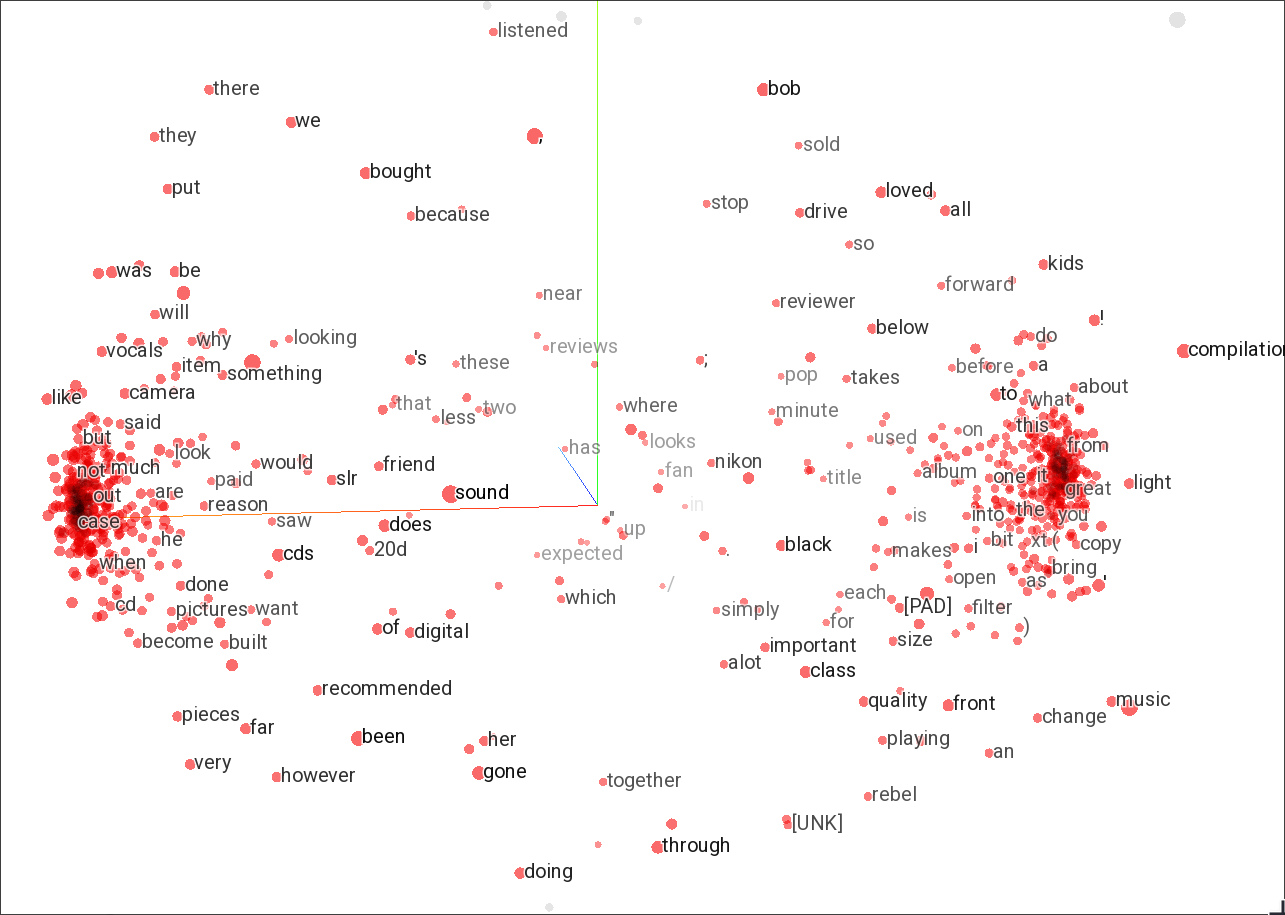

**Answer:**

Using the Kaiming He method achieved a 100% relative performance increase or halving the loss for both models for the same amount of compute. I used the following formula to initialize the weights of the embedding layer:

$$
\mathcal{U}(-\sqrt{k}, \sqrt{k})
$$

where $k$ is:

$$
k = \frac{1}{\text{in\_features}}
$$

In the case of embeddings, the $\text{in\_features}$ are the embeddings dimensions.

![PCA analysis of the sentiment analysis classifier using Kaiming He initialization](attachment:image.png)

Previously, we could not see any clustering in the PCA clustering image. However, as we can see above here, with $epochs=40$ and Kaiming He initialization, we can see clear clustering along one axis of the principal components. This suggests that this initialization method is also suitable for embedding layers.